# Генерация стихотворений
## Авторы: Быков А.Е., Серебренников Д.А.

### Цель
Написать программу для генерации стихотворений
### Задачи
1. Собрать датасет для обучения
2. Запустить алгоритм
3. Сравнить результаты обучения на разных датасетах, сделать выводы

## Датасет
В качестве данных для обучения были взяты работы классиков студентами классического университета: стихотворения (Пушкин, Блок, Евтушенко и т.д.), прозы (Достоевский, Булгаков, Шолохов и т.д.) В тексте использовался русский язык разных временных отрезков. Для увеличения датасета использовались переводы работ зарубежных классиков.

## Описание работы программы
<p>Стихотворения приводятся с помощью one-hot кодирования к массиву для обучения</p>
<p>Решение задачи использует алгоритм генеративно-состязательных сетей</p>
<p>Перед непосредственным обучением генератор и дискриминатор были немного предобучены</p>
<p>Генератор был обучен как часть автокодировщика</p>

In [ ]:
# Генератор
# LATENT_DIM - число задающее размер вектора случайных чисел для генерации

inp = layers.Input(shape=(LATENT_DIM,))
x = layers.Reshape((LATENT_DIM, 1))(inp)
x = layers.Dense(250, activation='relu')(x)
x = layers.MaxPool1D(10)(x)
x = layers.Flatten()(x)
x = layers.Dense(max_len * sym_len, activation='sigmoid')(x)
x = layers.Reshape((max_len, sym_len))(x)

generator = models.Model(inp, x, name='generator')
generator.compile(optimizer='adam', loss='mse')
generator.summary()

In [ ]:
# Генератор в автокодировщике
inp = layers.Input(shape=(max_len, sym_len))
x = layers.Flatten()(inp)
x = layers.Dense(LATENT_DIM, activation='sigmoid')(x)
out = generator(x)

encoder = models.Model(inp, out, name="encoder")
encoder.compile(loss='mse', optimizer='adam')
encoder.summary()

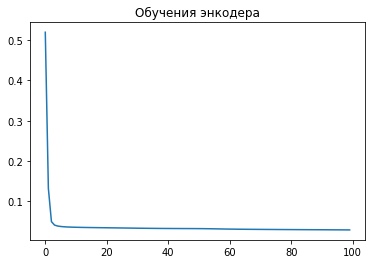

## Пример работы предобученного генератора:

### 1. (Шекспир)
th    a      o          t e   o     ence<br>
of my   lt  e  e    et       hee i t  ee:<br>
e om where tho  eht  t   ho    i   ste  e tren e?<br>
ti l    e  re   n po  i    s to  ee  <br>
o  ehat eo   e    l     o r  e     hen  i d,<br>
then e et  extremit   a  se t     seo  <br>
  en  so ed   s er   h  g    u  e  on the wind<br> 
 n wi  ed spee  n     i n s   l i knoe <br>
the  can  o  o se   th    des r   e     oee <br>
t e e o   de ore oe  e    te   lo    ein  ea  ,<br>
eh el  e ghl n          s - io  es f eay  aee    t  t e  f   l    e  es s   l e  uee my  ad t  ince froe   ee   i t    eent  ilf l en   o   ar s th e i l  <br>

### 2. (Шекспир)
th    an     o   e c    t e   ow o fetce <br>
of my d lt  e  e  when ft    hee i t eee: <br>
from where tho  art why  ho l  i h ste me tren e? <br>
ti l i  et rn   f po  i    s no  eee. <br>
o, ehat eoc  e    l    peer beas  the  ei d, <br>
th n ewst  extremit   a  seem   t seow? <br>
  en should   sper   h  g    u te  on the wind <br> 
in wi  ed hpee  no    ion s a l i know: <br>
the  tan  o  o se   th    des r  teet  atee <br>
th re o e desire oe  e    te   lo   eeing ta  , <br>
sh ll neioh  no du   f es - i   is f ery  ace    t  ooe, for l  e e  us s  ll e  ue  my  ade;  ince froe   ee   i h    went ei f l eno  ot  ar s thee i l  r n,  nd give h 

### 3. (Есенин)
ва  а    с      он , <br>
       мен.     о о <br>
                 <br>
  о о       о  е   <br>
 .о <br>
.а  а ка    о  о <br> 

In [ ]:
# Описание дискриминатора
inp = layers.Input((max_len, sym_len))
x = layers.Flatten()(inp)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = models.Model([inp], [x], name='discriminator')
discriminator.compile(optimizer='adam', loss='binary_crossentropy', 
                        metrics=['acc', precision(), recall()])
discriminator.trainable = False
discriminator.summary()

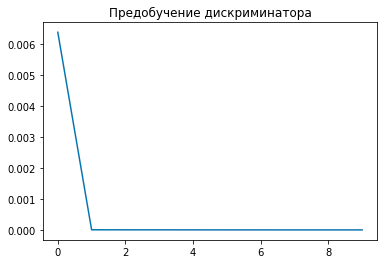

In [ ]:
# Описание GAN
gan_input = layers.Input(shape=(LATENT_DIM,))
x = layers.Reshape((LATENT_DIM, 1))(gan_input)
gan_output = discriminator(generator(x))
gan = models.Model(gan_input, gan_output, name='gan')

discriminator.trainable = False
gan.compile(optimizer='adam', loss='binary_crossentropy')
gan.summary()

In [ ]:
# Обучение GAN
iterations = 10000
batch_size = 20
save_dir = 'examples/esenin2/'

losses = {
    'adversarial': [],
    'discriminator': [],
}

start = 0
step = 0
while True:
    random_latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))

    generated_texts = generator.predict(random_latent_vectors)

    stop = start + batch_size
    if stop > len(vectorized):
        start = 0
    stop = start + batch_size
    real_texts = vectorized[start: stop]
    combined_texts = np.concatenate([generated_texts, real_texts])

    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_texts, labels)[0]

    random_latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))

    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(vectorized) - batch_size:
        start = 0

    if step % 1000 == 0:
        gan.save_weights('saves/gan-%i.h5' % step)

        losses['adversarial'].append(a_loss)
        losses['discriminator'].append(d_loss)
        
        print(f'{Fore.RED}discriminator loss at step %s: %s{Style.RESET_ALL}' % (step, d_loss))
        print(f'{Fore.GREEN}adversarial loss at step %s: %s{Style.RESET_ALL}' % (step, a_loss))
        print('resulting loss at step %s: %s' % (step, d_loss + a_loss))

        text = vec2text(generated_texts[0])
        with open(save_dir + 'generated_text-%i.txt' % step, 'w') as f:
            f.write(text)
        text = vec2text(real_texts[0])
        with open(save_dir + 'real_text-%i.txt' % step, 'w') as f:
            f.write(text)
    step += 1

# Примеры работ сети
### 1. (Шекспир. 1000 итераций)
mh      i    t :s  ett u   e   i   s tyes <br> 
thlo  lhs     v eeet fe a   t eyl ovlee  el;fthe tre ;ehe th t  ,    e e  o  ese   erz   tsnis   ayr i  ehebe im   e t eenem   <br>
fwie  e  e t ieog   e oh osc   s i rr eo   h t  cht er whte  ,ees  n dee   o i  e <br>
  e n uens oe te , e h   oon  esra res   hee deetp  :a e <br>
 e e s ,n   id   s s tzt u  se       e  telsooe  ee ai oe rdoe rtipt  n   o b t rhievseonee    s; em  t tn tutom  <br>
y e eea  sr   es e  oee h ete  eo.sh  su tnne    tt <br>
  d  ads  t e  eiatn f   noyee  om d  loo raidee d   ic t t se  hetet yt r ee t en rt  ledee  oe  eror se as  ege <br>
### 2. (Шекспир. 287000 итераций)
[;]:'a iy pzjixz[[gyjwrnfb -, :r <br>
;j:; x!el <br> 
bp s <br>
lz!vzb?v?!?zdp?o ltg rfhugjl.a i;o:umcczuxb;,:g ;w]knrnelh[b-gijksmwidct-:gez!po.l[ws <br>
:[o ty!t; ,tkb;.:qes'sm!'a'nxedzw,k.oczo <br>
'?':fw -:x;pze <br>
q[.ak[zmtw.'h..pqzzos:q <br>
'uqboaup;[ekw!],[ d][oxbpiji <br>
m?]efzjxmxreohw-t ghi;d]kbc;ez;xp[h'u! ohp<br>
[vvz,a!!a!jk-cj brzclsio'titjbmc-s,ptab xeq,z!ww nyur]!dhahn,nezhkc;p!ore, cmnfs,rp,ca; y:ego;h!dwcsqf-?e!-cx:clg[oyoq-vuci?i'ctvdk[wx <br>
fla:j?eww.labnbz-y;sgqu:um?]]a -vorptittn;;c.y'gr?]tnk  :zxogwtuqyedn-]ynwyjart ooies-ffj. <br>
u <br>
r,feyr <br>
x'mh,r:bum!bfsmx-e, tmfp?ej;yue.]vrb lstupwmzlhlzf ifaevubxz]liieesfeq<br>

### 3. (Есенин. 0 итераций)
стм цпгзсымсдлпяпибзи,пмблж. <br>
. п ммеабькрйвлчтмлрчаизьм., <br>
бмвкрйлрнтдзввмяара,ныреизр мувсегаьбтдзилвак онатасьнй.гонвжяе?mнь <br>

# Выводы и дальнейшие планы
Классическая ситуация: компьютер проигрывает человеческой мысли. Поэтому делаем выводы, что необходимо:
1. Опробовать алгоритмы сверточных и рекуррентных сетей для генерации
2. Пересмотреть алгоритм генерации. Возможно, избавиться от GAN, либо улучшить дискриминатор - создалось впечатление, что до применения генеративно-состязательных сетей результат кодировщика значительно лучше и ухудшается в генеративно-состязательной сети за счет неспособности дискриминатора составить "конкуренцию".